In [4]:
import pandas as pd
uselog = pd.read_csv('../rawdata/use_log.csv')
customer = pd.read_csv("../rawdata/customer_join.csv")

In [5]:
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [6]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 1 0 2]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


In [11]:
customer_clustering.columns = ["월평균값", "월중앙값", "월최댓값", "월최솟값", "회원기간", "cluster"]

In [12]:
customer_clustering.groupby("cluster").count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,763,763,763,763,763
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [14]:
customer_clustering.groupby("cluster").mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,3.054713,2.888598,4.756225,1.653997,9.263434
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


In [15]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

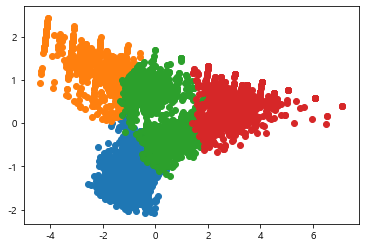

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

In [25]:
customer_clustering = pd.concat([customer_clustering, customer], axis = 1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index = False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,1,763
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [30]:
# 정기 비정기 이용 여부 파악
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,228
1,0,1,1106
2,1,0,497
3,1,1,266
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


In [31]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)

In [32]:
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [33]:
year_months = list(uselog_months["연월"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [35]:
uselog_months

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [37]:
year_months

['201804',
 '201805',
 '201806',
 '201807',
 '201808',
 '201809',
 '201810',
 '201811',
 '201812',
 '201901',
 '201902',
 '201903']

In [38]:
tmp

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201903,AS002855,4,5.0,6.0,2.0,5.0,3.0,7.0
1,201903,AS008805,1,6.0,1.0,5.0,3.0,2.0,2.0
2,201903,AS009373,5,6.0,7.0,4.0,4.0,5.0,6.0
3,201903,AS015233,8,4.0,9.0,9.0,7.0,7.0,9.0
4,201903,AS015315,4,5.0,5.0,5.0,7.0,4.0,7.0
...,...,...,...,...,...,...,...,...,...
2948,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
2949,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
2950,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
2951,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


In [40]:
tmp_before

,customer_id,count_5
15424,AS002855,7
15425,AS008805,2
15426,AS009373,6
15427,AS015233,9
15428,AS015315,7
...,...,...
18527,TS995299,5
18528,TS998593,9
18529,TS999079,4
18530,TS999231,4


In [41]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [42]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [43]:
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [44]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
print(model.score(X_train, y_train))

0.5974061178601278


In [46]:
print(model.score(X_test, y_test))

0.6365356395029446


In [48]:
# 모델 기여 변수 확인
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.311734
1,count_1,0.199967
2,count_2,0.178882
3,count_3,0.194718
4,count_4,0.050021
5,count_5,0.063008
6,period,0.060757


In [49]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [50]:
model.predict(x_pred)

array([3.77080118, 2.03300541])

In [52]:
uselog_months.to_csv("../output/use_log_months.csv", index=False)